In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from great_tables import GT
import os

%precision 4
%matplotlib inline
sns.set_theme(style="white", palette="pastel")
os.makedirs('plots', exist_ok=True)

In [1]:
#!jupyter nbconvert analyzer.ipynb --to html --output report.html --no-input --execute --no-prompt

In [2]:
data = pd.read_csv('sample.csv')

def extract_form(row):
    parts = row.split(' | ')
    form_name = parts[0]
    form_number = int(parts[1].replace('Form ', ''))
    return form_name, form_number

data[['Form', 'Form Number']] = pd.DataFrame(data['Exam Take'].apply(extract_form).tolist(), index=data.index)
data['Date Time'] = data['Exam Take'].str.extract(r'(\d+/\d+/\d+ \| \d+:\d+\w{2})')
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%m/%d/%Y | %I:%M%p')

data = data.sort_values(by=['Date Time', 'Form Number', 'Seq'])
split_columns = data['Content Description'].str.split(':', expand=True, n=2)
split_columns.columns = ['General Topic', 'Subtopic', 'Subsubtopic']
split_columns['Subsubtopic'] = split_columns['Subsubtopic'].fillna('')
data = pd.concat([data, split_columns], axis=1).drop(columns=['Answer Explanation', 'Exam Take', 'Content Description'])
data

,Correct / Incorrect,Seq,Question Id,Content Topic,Answer Selected,Time (sec),Timing,Form,Form Number,Date Time,General Topic,Subtopic,Subsubtopic
1,Correct,1,SAMK2614MAG1636,Foundational science,B,61.466,Self-Paced,Comp Basic Sci SELF,25,2023-09-20 22:29:00,Cardio,congenital disorders,
11,Incorrect,2,SCAD1905MAM6240,Foundational science,D,27.911,Self-Paced,Comp Basic Sci SELF,25,2023-09-20 22:29:00,Immune,transplantation,
15,Correct,3,SCAD7107MAN6823,Foundational science,D,61.597,Self-Paced,Comp Basic Sci SELF,25,2023-09-20 22:29:00,Multi,vitamin deficiencies and/or toxicities,
22,Incorrect,4,SCAD9668MAN9424,Biostatistics/epidemiology,B,81.360,Self-Paced,Comp Basic Sci SELF,25,2023-09-20 22:29:00,Biostat,"sensitivity, specificity, predictive values",
26,Correct,5,SCAP6487MAZ4602,Foundational science,C,201.643,Self-Paced,Comp Basic Sci SELF,25,2023-09-20 22:29:00,Gastro,disorders of the liver,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,Incorrect,196,SCBT3614MCB2950,Foundational science,E,73.904,Standard-Paced,Comp Basic Sci SELF,30,2024-03-19 13:20:00,Endo,hypoglycemia and islet cell disorders,
1180,Incorrect,197,SCBT9357MCB8327,Diagnosis,C,45.025,Standard-Paced,Comp Basic Sci SELF,30,2024-03-19 13:20:00,Skin/Subq,adverse effects of drugs,
1185,Incorrect,198,SCBU8209MCC6640,Foundational science,A,58.532,Standard-Paced,Comp Basic Sci SELF,30,2024-03-19 13:20:00,MSK,congenital disorders,
1189,Correct,199,SCBU8678MCC7104,Foundational science,D,38.464,Standard-Paced,Comp Basic Sci SELF,30,2024-03-19 13:20:00,GenPrin,fungal structure,


In [ ]:
# Group by Date Time and calculate the percentage of correct answers
data['Correct'] = data['Correct / Incorrect'] == 'Correct'
percent_correct = data.groupby(data['Date Time'].dt.date)['Correct'].mean().reset_index()
percent_correct.columns = ['Date', 'Percent Correct']

# Get the form numbers for each date
form_numbers = data.groupby(data['Date Time'].dt.date)['Form Number'].first().reset_index()
form_numbers.columns = ['Date', 'Form Number']

# Merge the form numbers with the percent correct data
percent_correct = pd.merge(percent_correct, form_numbers, on='Date')

# Plot the line graph
plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Percent Correct', data=percent_correct, linewidth=2.5, color='black')

# Add labels to each point
for i in range(len(percent_correct)):
    plt.text(percent_correct['Date'][i], percent_correct['Percent Correct'][i], 
             percent_correct['Form Number'][i], fontsize=12, ha='right')

plt.title('Percentage of Correct Answers Over Time')
plt.xlabel('Date')
plt.ylabel('Percent Correct')
plt.xticks(rotation=45)
plt.savefig('plots/percent_correct.png')

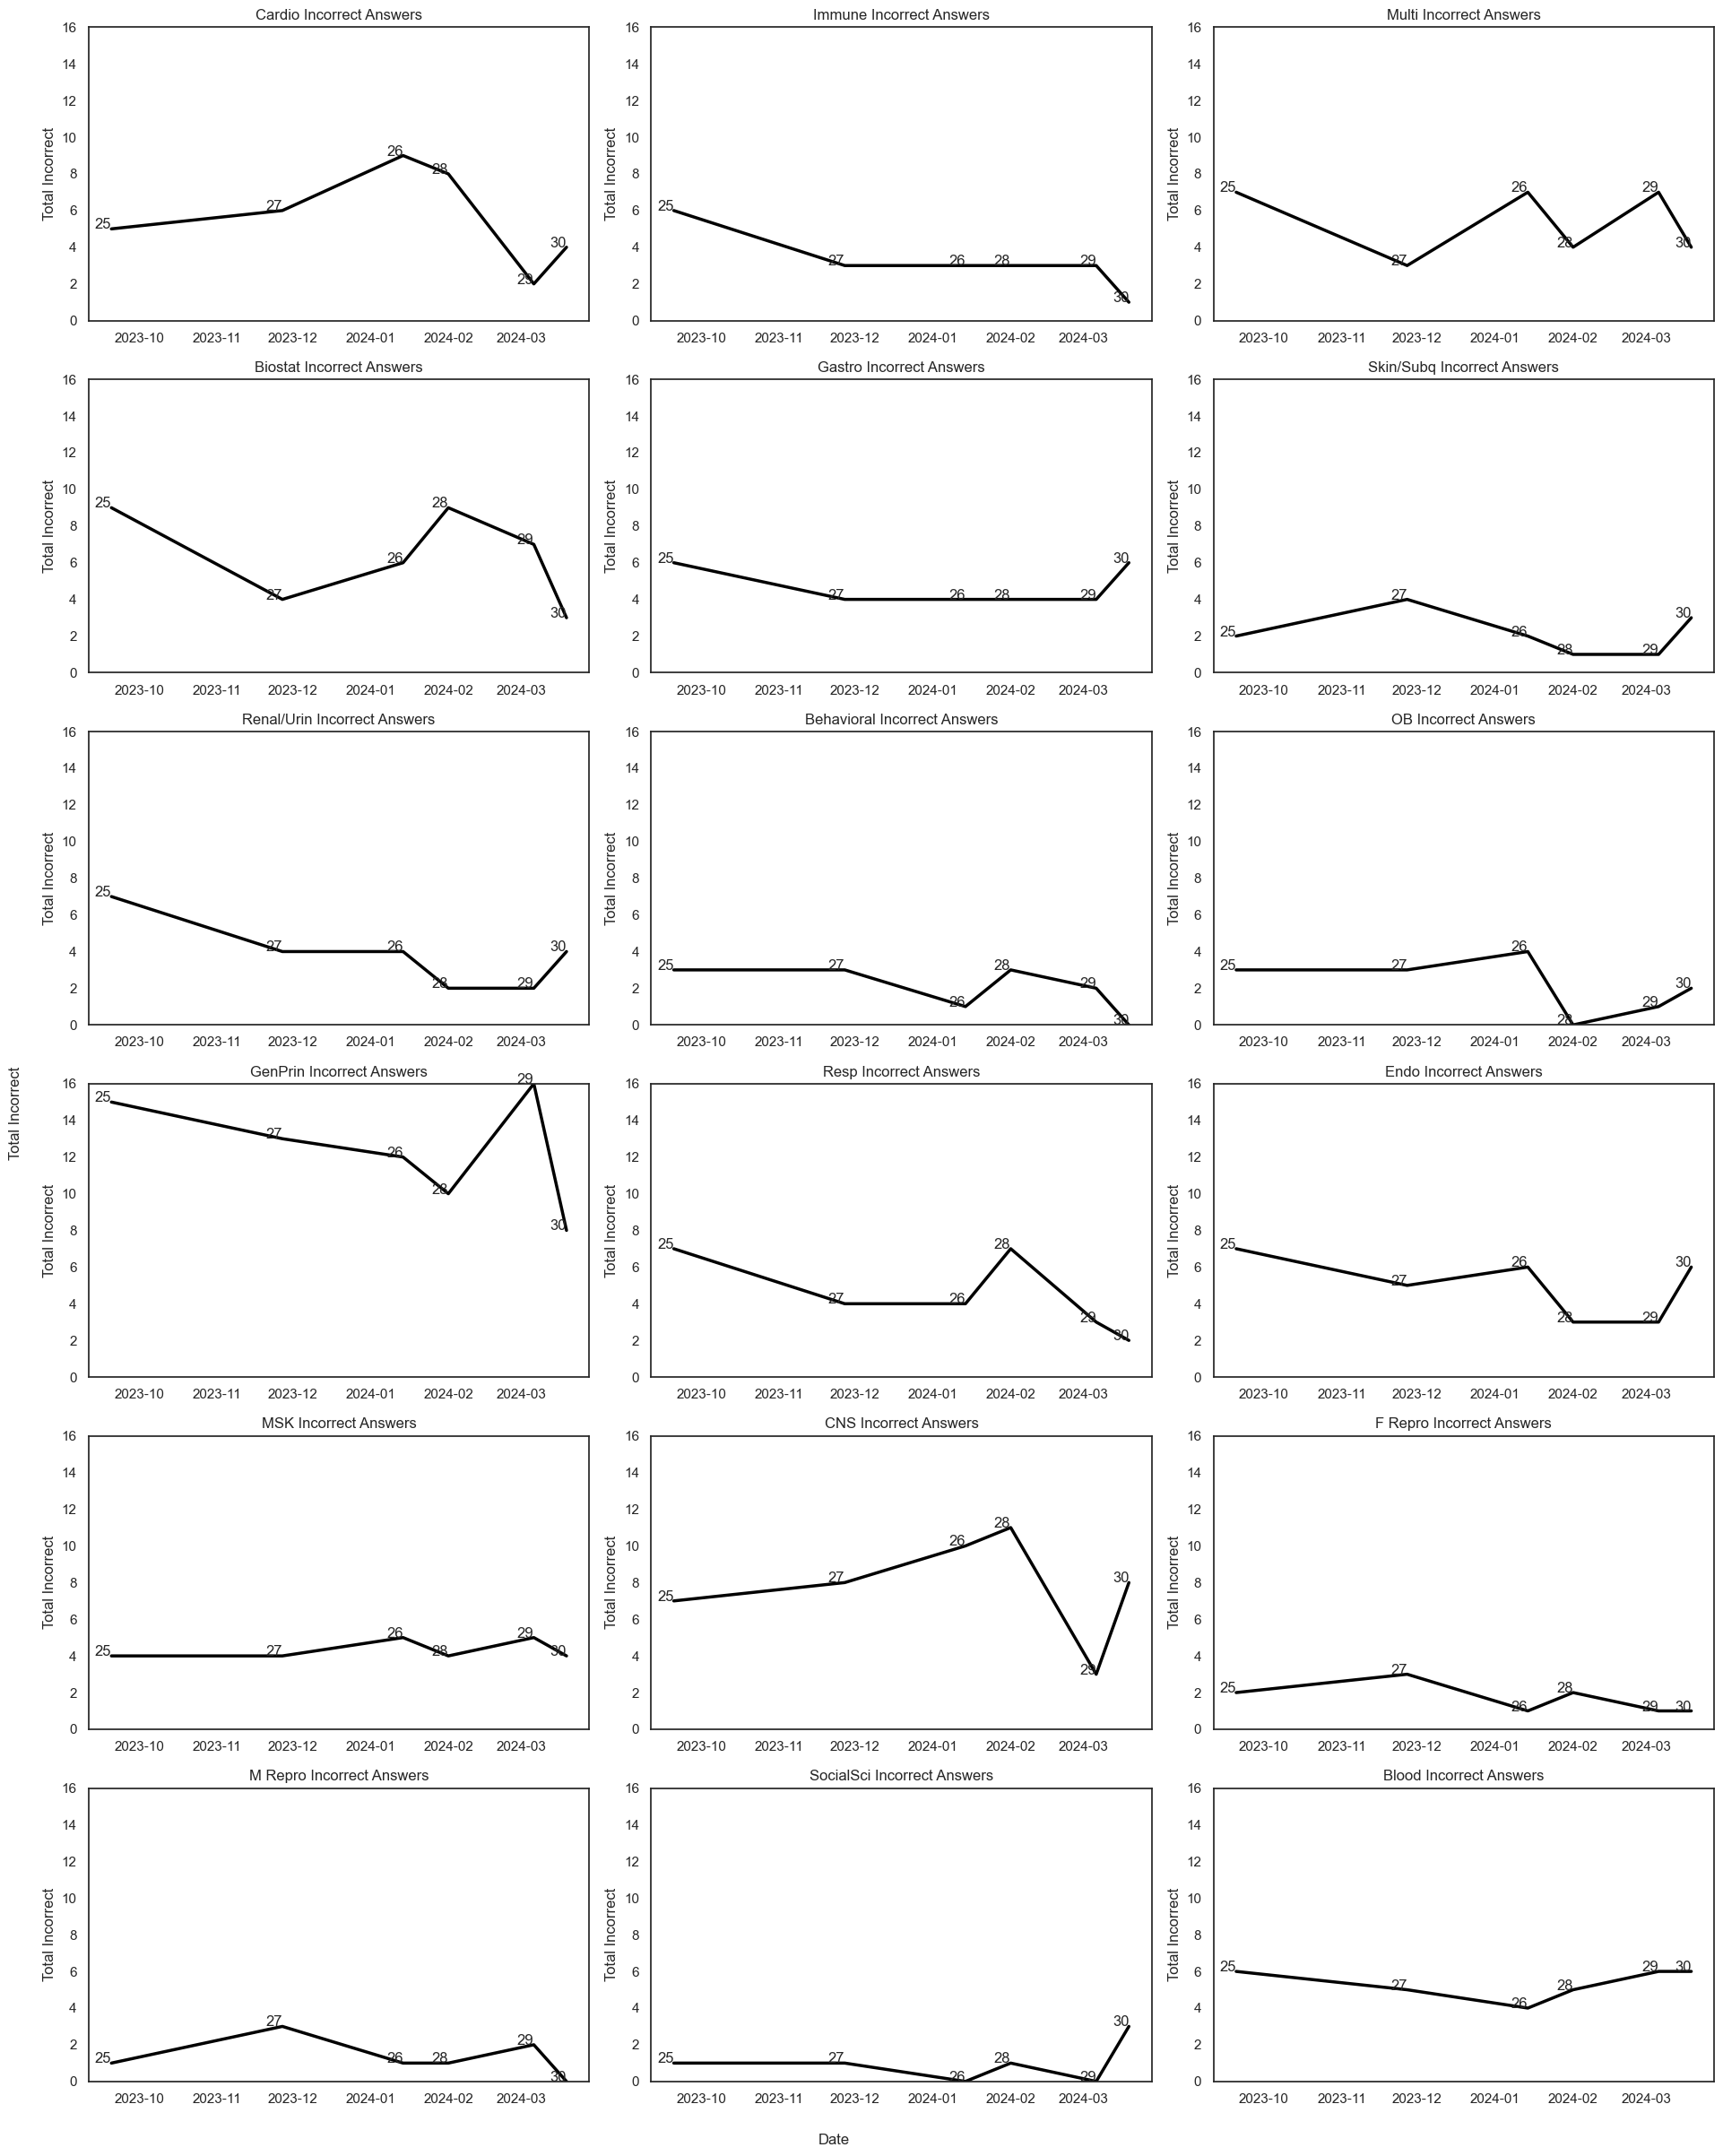

In [3]:
general_topics = data['General Topic'].unique()
fig, axes = plt.subplots(6, 3, figsize=(20, 25))
axes = axes.flatten()
max_incorrects_by_topic = data[data['Correct / Incorrect'] == 'Incorrect'].groupby(['Date Time', 'General Topic']).size().reset_index(name='Total Incorrects')['Total Incorrects'].max()

for i, topic in enumerate(general_topics):
    if i >= len(axes):
        break

    topic_data = data[data['General Topic'] == topic].copy()
    topic_data['Incorrect'] = topic_data['Correct / Incorrect'].ne('Correct')
    total_incorrect_topic = topic_data.groupby(topic_data['Date Time'].dt.date)['Incorrect'].sum().reset_index()
    total_incorrect_topic.columns = ['Date', 'Total Incorrect']
    form_numbers_topic = topic_data.groupby(topic_data['Date Time'].dt.date)['Form Number'].first().reset_index()
    form_numbers_topic.columns = ['Date', 'Form Number']
    total_incorrect_topic = pd.merge(total_incorrect_topic, form_numbers_topic, on='Date')

    sns.lineplot(x='Date', y='Total Incorrect', data=total_incorrect_topic, linewidth=2.5, color='black', ax=axes[i])

    for j in range(len(total_incorrect_topic)):
        axes[i].text(total_incorrect_topic['Date'][j], total_incorrect_topic['Total Incorrect'][j], 
                     total_incorrect_topic['Form Number'][j], fontsize=12, ha='right')
        axes[i].set_ylim(0, max_incorrects_by_topic)
    axes[i].set_title(f'{topic} Incorrect Answers')

for i in range(len(general_topics), len(axes)):
    axes[i].axis('off')

for ax in axes:
    ax.set_xlabel('')

for ax in axes[:len(general_topics):3]:
    ax.set_ylabel('Total Incorrect')

fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Total Incorrect', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('plots/total_incorrects_by_topic.png')

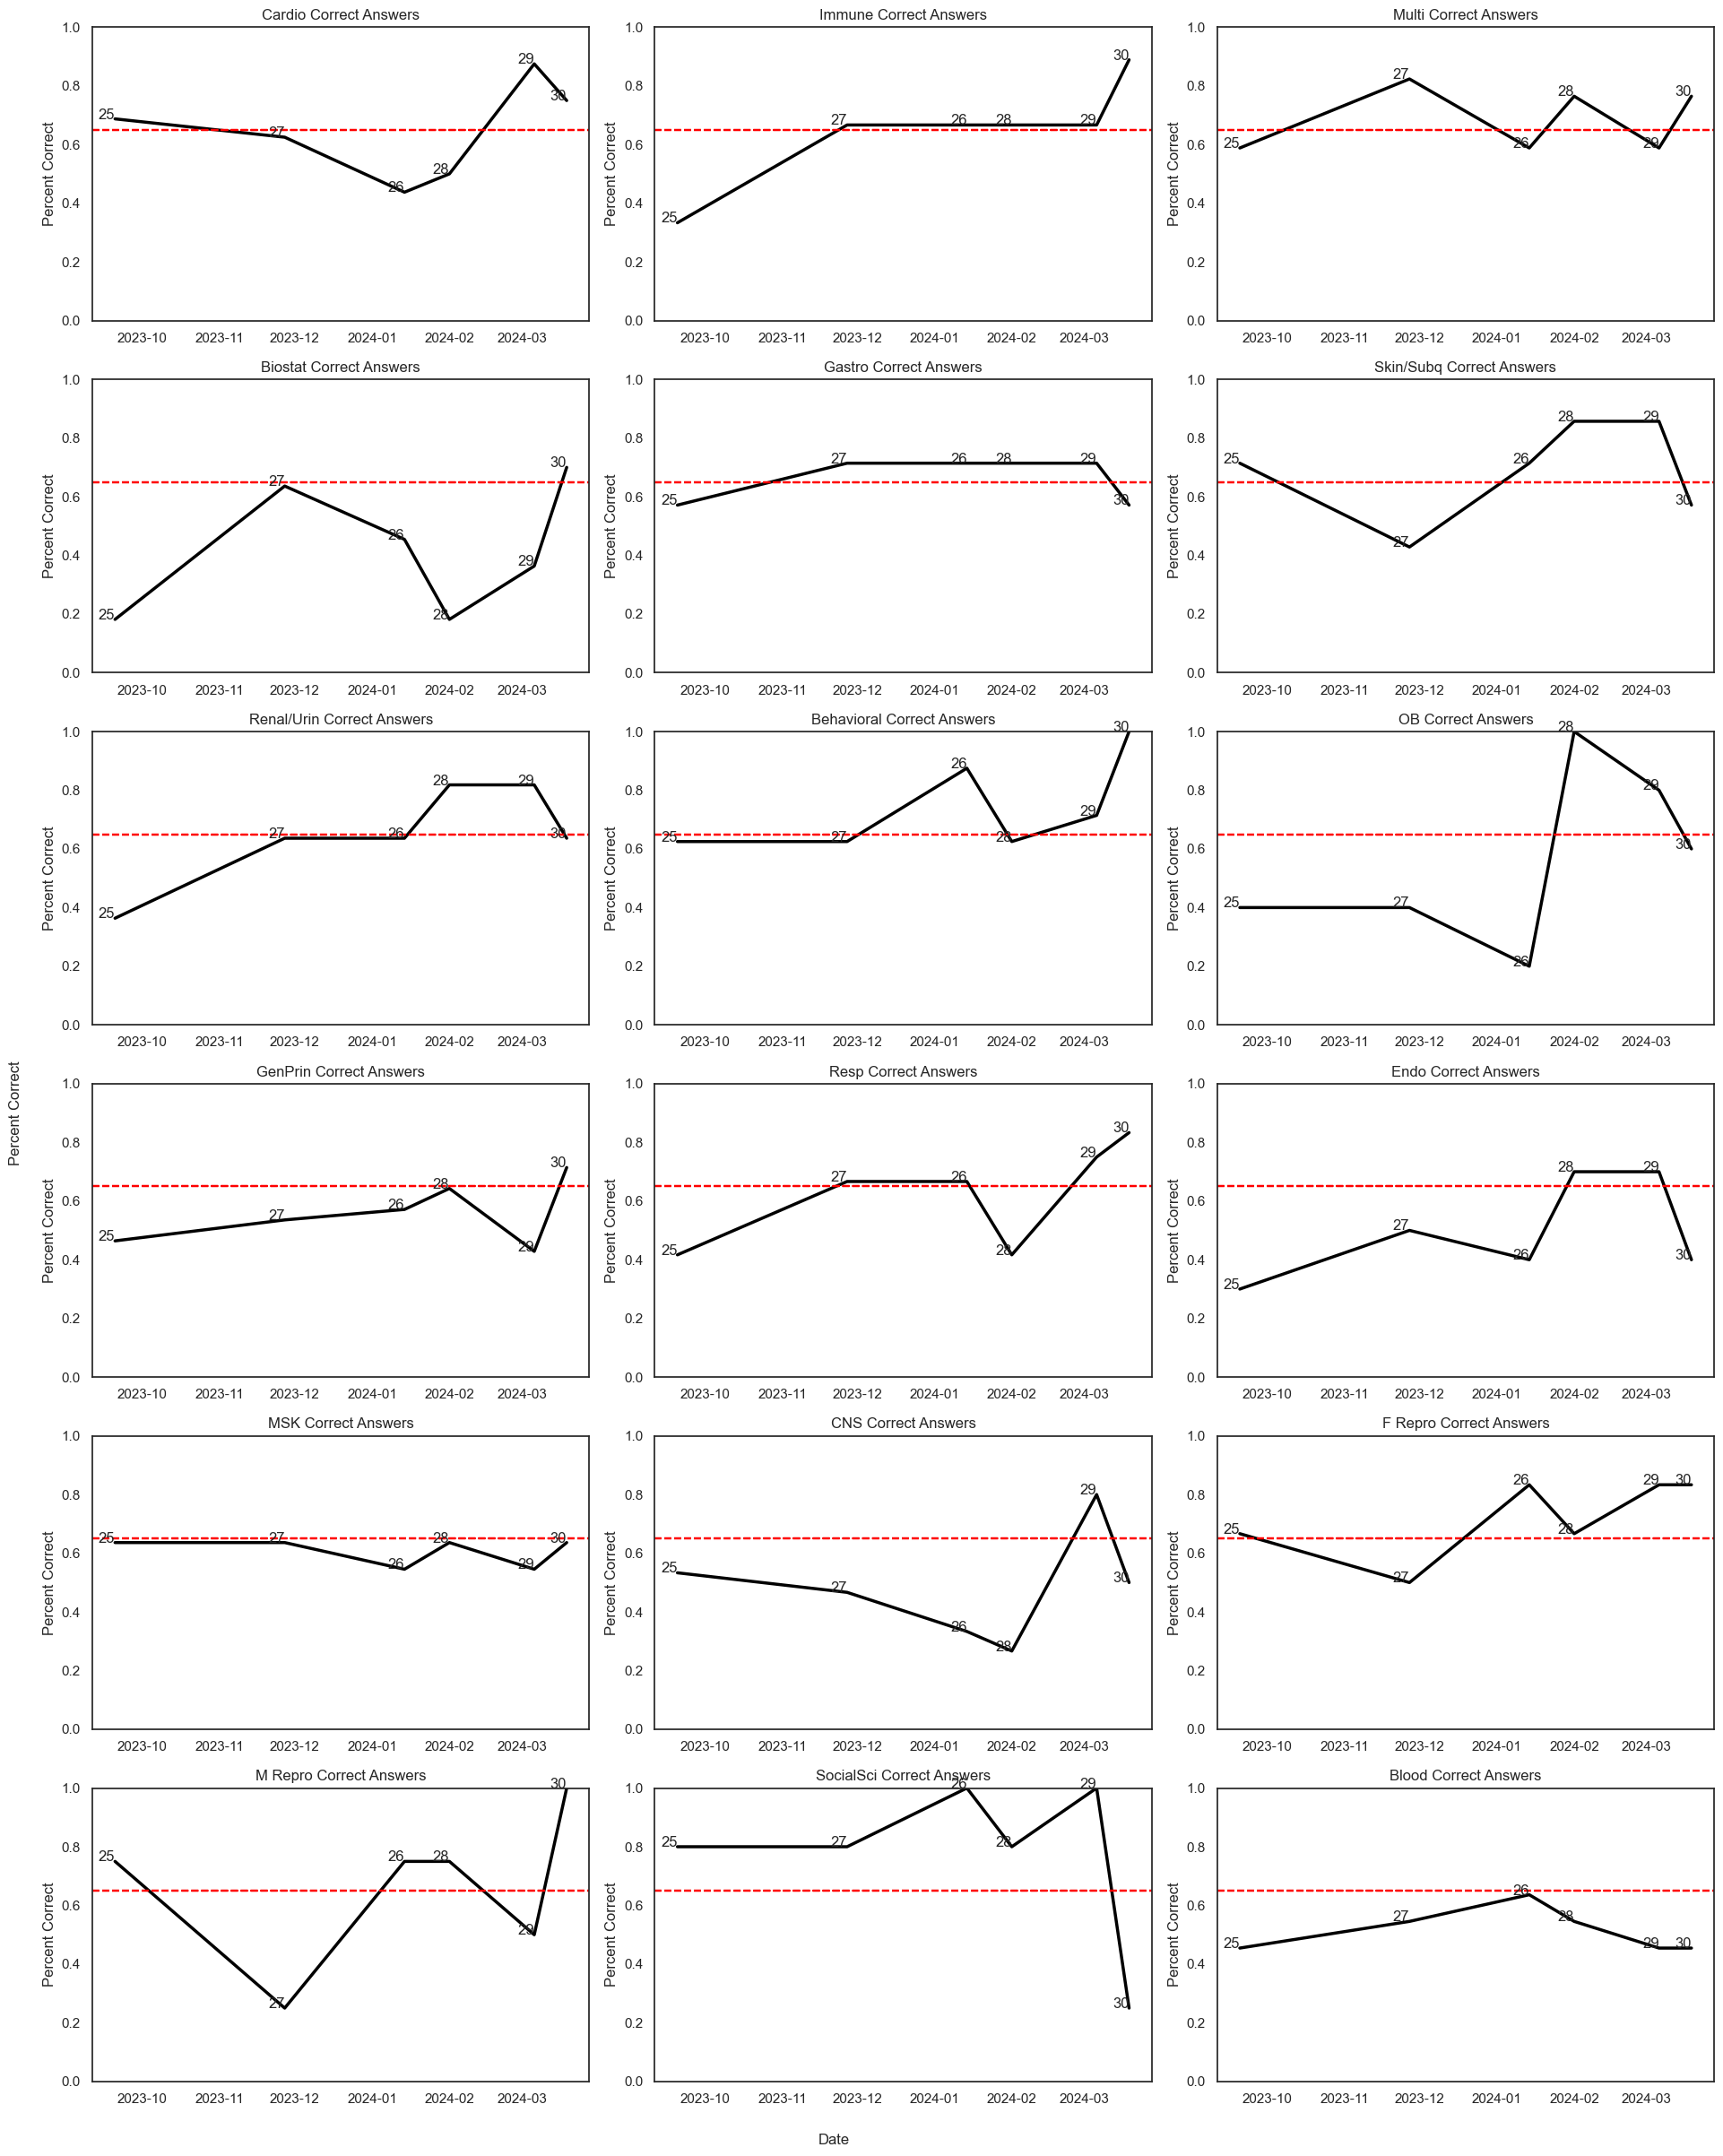

In [4]:
general_topics = data['General Topic'].unique()
fig, axes = plt.subplots(6, 3, figsize=(20, 25))
axes = axes.flatten()

for i, topic in enumerate(general_topics):
    if i >= len(axes):
        break

    topic_data = data[data['General Topic'] == topic].copy()
    topic_data['Correct'] = topic_data['Correct / Incorrect'].eq('Correct')
    percent_correct_topic = topic_data.groupby(topic_data['Date Time'].dt.date)['Correct'].mean().reset_index()
    percent_correct_topic.columns = ['Date', 'Percent Correct']
    form_numbers_topic = topic_data.groupby(topic_data['Date Time'].dt.date)['Form Number'].first().reset_index()
    form_numbers_topic.columns = ['Date', 'Form Number']
    percent_correct_topic = pd.merge(percent_correct_topic, form_numbers_topic, on='Date')

    sns.lineplot(x='Date', y='Percent Correct', data=percent_correct_topic, linewidth=2.5, color='black', ax=axes[i])

    for j in range(len(percent_correct_topic)):
        axes[i].text(percent_correct_topic['Date'][j], percent_correct_topic['Percent Correct'][j], 
                     percent_correct_topic['Form Number'][j], fontsize=12, ha='right')
        axes[i].axhline(0.65, color='red', linestyle='--', label='target')
    axes[i].set_title(f'{topic} Correct Answers')
    axes[i].set_ylim(0, 1)

for i in range(len(general_topics), len(axes)):
    axes[i].axis('off')

for ax in axes:
    ax.set_xlabel('')

for ax in axes[:len(general_topics):3]:
    ax.set_ylabel('Percent Correct')

fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Percent Correct', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('plots/percent_correct_by_topic.png')

In [5]:
incorrect_counts = data[data['Correct / Incorrect'] == 'Incorrect'].groupby('General Topic').size().reset_index(name='Number of Incorrects')
total_counts = data.groupby('General Topic').size().reset_index(name='Total Answers')
merged_counts = pd.merge(incorrect_counts, total_counts, on='General Topic')
average_time = data.groupby('General Topic')['Time (sec)'].mean().reset_index(name='Average Time (sec)')
merged_counts = pd.merge(merged_counts, average_time, on='General Topic')
merged_counts['Percentage of Incorrects'] = (merged_counts['Number of Incorrects'] / merged_counts['Total Answers']) * 100
merged_counts = merged_counts.sort_values(by = 'Number of Incorrects', ascending = False)
#GT(merged_counts)
merged_counts

,General Topic,Number of Incorrects,Total Answers,Average Time (sec),Percentage of Incorrects
8,GenPrin,74,168,82.726030,44.047619
3,CNS,47,91,97.713396,51.648352
1,Biostat,38,65,94.922508,58.461538
4,Cardio,34,96,101.148167,35.416667
2,Blood,32,66,122.598258,48.484848
12,Multi,32,102,90.036324,31.372549
5,Endo,30,60,117.791467,50.000000
7,Gastro,28,84,81.977179,33.333333
15,Resp,27,72,109.257667,37.500000
11,MSK,26,66,104.141591,39.393939


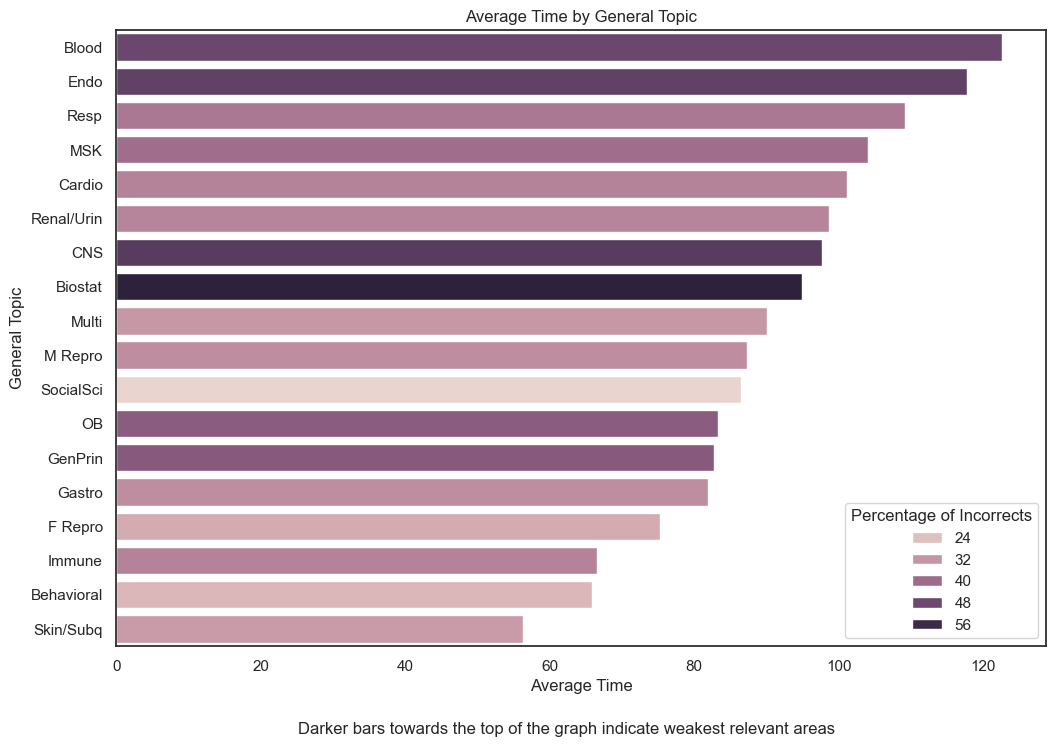

In [6]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Average Time (sec)', y='General Topic', 
            data=merged_counts.sort_values(by='Average Time (sec)', ascending=False), 
            hue='Percentage of Incorrects', dodge=False)
plt.title('Average Time by General Topic')
plt.figtext(0.5, -0.0, "Darker bars towards the top of the graph indicate weakest relevant areas", ha="center", fontsize=12)
plt.xlabel('Average Time')
plt.ylabel('General Topic')
plt.legend(title='Percentage of Incorrects', loc='lower right')
plt.savefig('plots/average_time_by_topic.png')

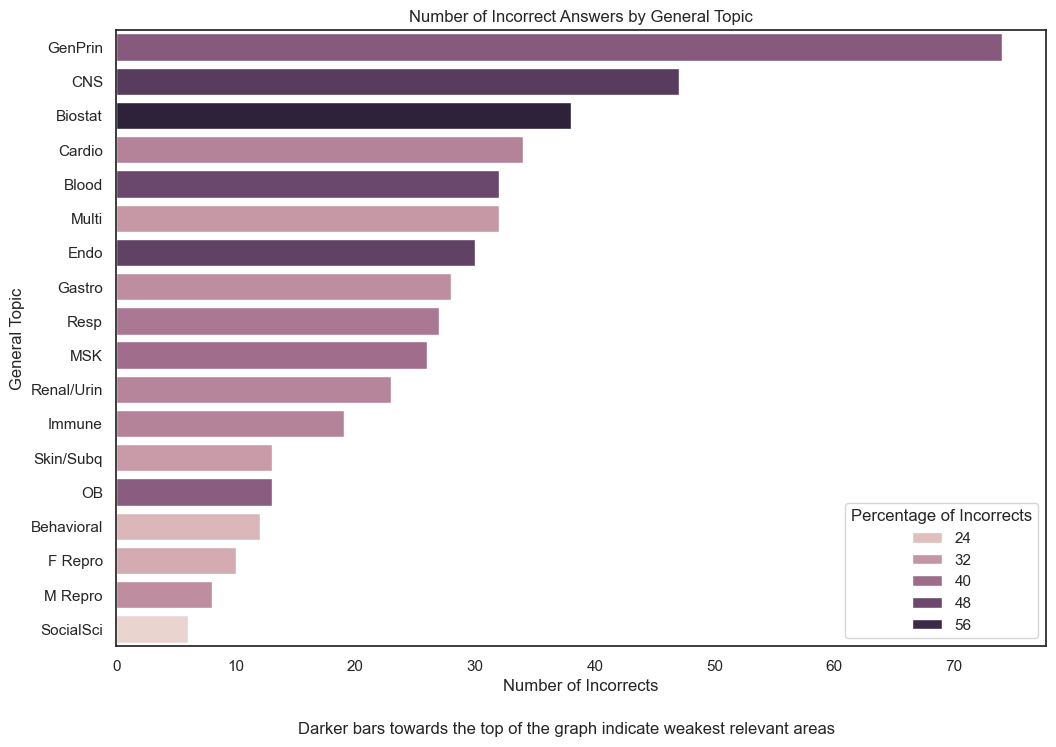

In [7]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Incorrects', y='General Topic', 
            data=merged_counts.sort_values(by='Number of Incorrects', ascending=False), 
            hue='Percentage of Incorrects', dodge=False)
plt.title('Number of Incorrect Answers by General Topic')
plt.figtext(0.5, -0.0, "Darker bars towards the top of the graph indicate weakest relevant areas", ha="center", fontsize=12)
plt.xlabel('Number of Incorrects')
plt.ylabel('General Topic')
plt.legend(title='Percentage of Incorrects', loc='lower right')
plt.savefig('plots/number_incorrects_by_topic.png')

In [8]:
most_incorrect_topic = merged_counts.iloc[0:3]['General Topic']

filtered_data = data[data['General Topic'].isin(most_incorrect_topic)]

incorrect_counts_subtopic = filtered_data[filtered_data['Correct / Incorrect'] == 'Incorrect'].groupby('Subtopic').size().reset_index(name='Number of Incorrects')
total_counts_subtopic = filtered_data.groupby('Subtopic').size().reset_index(name='Total Answers')
merged_counts_subtopic = pd.merge(incorrect_counts_subtopic, total_counts_subtopic, on='Subtopic')
merged_counts_subtopic['Percentage of Incorrects'] = (merged_counts_subtopic['Number of Incorrects'] / merged_counts_subtopic['Total Answers']) * 100
merged_counts_subtopic = merged_counts_subtopic.sort_values(by='Number of Incorrects', ascending=False)

#GT(merged_counts_subtopic.head(10))
merged_counts_subtopic.head(10)

,Subtopic,Number of Incorrects,Total Answers,Percentage of Incorrects
64,study design,8,18,44.444444
25,gene expression,7,12,58.333333
23,energy metabolism,6,9,66.666667
13,"cell/tissue structure, regulation, function",5,6,83.333333
32,incidence/prevalence,5,7,71.428571
14,cerebrovascular disease,5,11,45.454545
59,"sensitivity, specificity, predictive values",4,5,80.000000
43,motor systems,4,4,100.000000
26,genetic mechanisms,4,6,66.666667
9,brain metabolism,4,4,100.000000


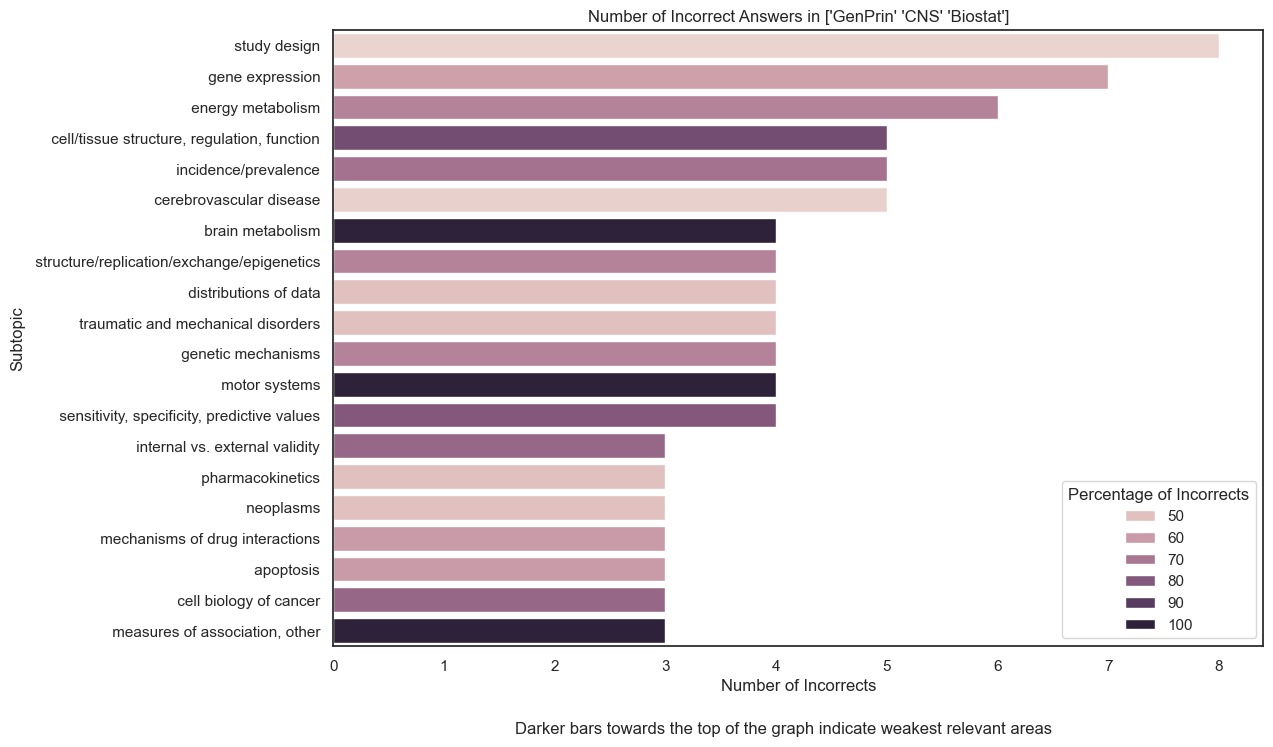

In [9]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Incorrects', y='Subtopic', 
            data=merged_counts_subtopic.iloc[0:20].sort_values(by='Number of Incorrects', ascending=False), 
            hue='Percentage of Incorrects', dodge=False)
plt.title(f'Number of Incorrect Answers in {most_incorrect_topic.values}')
plt.figtext(0.5, -0.0, "Darker bars towards the top of the graph indicate weakest relevant areas", ha="center", fontsize=12)
plt.xlabel('Number of Incorrects')
plt.ylabel('Subtopic')
plt.legend(title='Percentage of Incorrects', loc='lower right')
plt.savefig('plots/number_incorrects_by_subtopic.png')

In [10]:
data_with_incorrects = data[data['Correct / Incorrect'] == 'Incorrect'].groupby('Content Topic').size().index.values
data_with_incorrects = data[data['Content Topic'].isin(data_with_incorrects)]

average_time_per_topic = data_with_incorrects.groupby('Content Topic')['Time (sec)'].mean().reset_index()
average_time_per_topic.columns = ['Content Topic', 'Average Time (sec)']

average_time_per_topic['Number of Incorrects'] = data_with_incorrects[data_with_incorrects['Correct / Incorrect'] == 'Incorrect'].groupby('Content Topic').size().values
average_time_per_topic['Number of Questions'] = data_with_incorrects.groupby('Content Topic').size().values
average_time_per_topic['Percentage of Incorrects'] = (average_time_per_topic['Number of Incorrects'] / average_time_per_topic['Number of Questions']) * 100

average_time_per_topic = average_time_per_topic.sort_values(by=['Average Time (sec)'], ascending=False)
#GT(average_time_per_topic)
average_time_per_topic

,Content Topic,Average Time (sec),Number of Incorrects,Number of Questions,Percentage of Incorrects
3,Gathering information,110.335133,2,15,13.333333
4,History/physical exam,97.263270,16,37,43.243243
1,Diagnosis,96.126602,57,221,25.791855
0,Biostatistics/epidemiology,95.834141,37,64,57.812500
2,Foundational science,90.492559,355,843,42.111507
5,Making decisions,74.063000,1,1,100.000000
7,Supporting emotions,51.692750,3,4,75.000000
6,Principles of EBM/application of pt care,36.578000,1,1,100.000000
